In [163]:
import pandas as pd

# read data
df = pd.read_excel('../../GQ_102101.xlsx') # 原始資料要存在資料夾以外這樣才不會 Push 上去 或你 gitignore 也可以

In [165]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# set style
mpl.style.use("ggplot")

# plot inline
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei'] # for chinese font usage 
plt.rcParams['axes.unicode_minus']=False

In [166]:
# assign appropriate data type
# year of grad: 依照學號中間三碼分出入學年度 year_of_start
def year_of_grad(student_id):
    
    year = student_id[4:7]
    
    return(year)
df['year_of_start'] = df['請問您的學號？(B101100100)'].apply(lambda x: year_of_grad(x))

In [168]:
df.groupby(by = 'year_of_start').count()['時間戳記'] # 每一個入學年份的數量：此份問卷理論上收集的是100(已畢業才收集),101,102級的畢業生

year_of_start
099      3
100     22
101    180
102    168
103      1
104      2
110      1
Name: 時間戳記, dtype: int64

In [219]:
# 現在來檢查為什麼會有一些奇怪的入學年度出現
df.loc[df['year_of_start'] == '110']['請問您的學號？(B101100100)'] # 打錯字 --> 101 (來自未來的你，安安！)

296    b1011102080
Name: 請問您的學號？(B101100100), dtype: object

In [220]:
df.loc[df['year_of_start'] == '104']['請問您的學號？(B101100100)'] # 轉系生 (但我還是有點想不通為什麼 104 入學的轉系生已經可以畢業了)

341    b506104025
371    b117104013
Name: 請問您的學號？(B101100100), dtype: object

In [221]:
df.loc[df['year_of_start'] == '103']['請問您的學號？(B101100100)'] # 轉系生 (但我還是有點想不通為什麼 103 入學的轉系生已經可以畢業了)

271    b409103046
Name: 請問您的學號？(B101100100), dtype: object

In [172]:
# for simplicity, import 102 contact to find real 102 因為用入學年份粗分六七年制會很髒(有轉系、有擋修臨床而延後等等)，最後使用102及通訊錄中的學號(包含轉系生)來選出六年制的人是那些
contact = pd.read_excel('../../102contacts.xlsx')
true_six_year = [x.lower() for x in contact['Student_id']] # lowercase 都改小寫

In [173]:
len(true_six_year) # 102級的通訊錄中總共有174人(比實際應屆進入醫院的人還多，但是晚進醫院的人應該還沒有要寫問卷所以這個集合是合理的估計方式)

174

In [174]:
df['請問您的學號？(B101100100)'] = df['請問您的學號？(B101100100)'].apply(lambda x: x.lower()) # 自評問卷的學號也改小寫

In [175]:
df['six_year'] = df['請問您的學號？(B101100100)'].isin(true_six_year) # six_year 這個變數儲存的是：這個學號是否出現在 102的通訊錄裡。若 six_year = True 這就是六年制的同學(嗨麻吉)

In [176]:
df['six_year'].sum() # 總共有 164 位六年制的同學年寫了醫學生自評問卷

164

In [177]:
df.shape # 總共有 377 人填寫，164位是六年制；377-164 = 213 位是七年制；此份問卷共有 175個問題

(377, 175)

In [178]:
df.columns[df.columns.str.contains('2-5')] # 因為看見大量 NaN，回去看原始資料，似乎在收一開始的問卷的時候就有重複的問題，這些問題在有些人已經填寫以後才被拿掉。故在此次分析中這四個問題我就殺掉了

Index(['2-5: 小組討論課程（ PBL等小組討論課程 ） [份量適中]',
       '2-5: 小組討論課程（ PBL等小組討論課程 ） [對我很有幫助]',
       '2-5: 小組討論課程（ PBL等小組討論課程 ） [內容合宜]',
       '2-5: 小組討論課程（ PBL等小組討論課程 ） [有與臨床應用整合]'],
      dtype='object')

In [179]:
df.drop(columns = df.columns[df.columns.str.contains('2-5')], inplace = True) # 重複的問題要丟掉

In [181]:
# change scaling to 1,2,3,4,5 (非常不滿意，不滿意，普通，滿意，非常不滿意)
# 此份問卷不同的問題有不同的中文表達滿意程度，在這裡我通通把它轉成 1-5 分 (這是非常惱人的設計問卷的方式!)
scaling = {'非常不滿意':1,
          '不滿意':2,
          '普通':3,
          '滿意':4,
          '非常滿意':5,
          '良好':4,
          '非常良好':5,
          '不佳':2,
          '非常不佳':1,
          '非常清楚':5,
          '非常不清楚':1,
          '清楚':4,
          '不清楚':2}
df.iloc[:, 2:-2] = df.iloc[:, 2:-2].applymap(lambda x: scaling[x] if x in scaling.keys() else x) # 若問題是用1-5芬可以轉換的就轉換，不能轉的就保留原本的文字(像是：我的第一志願是？精神科﹔則保留"精神科")

In [182]:
df_m = df.groupby(by = 'six_year').mean() # 分組為六年制與七年制，計算每一項分數的平均值

In [183]:
df_m = df_m.transpose(copy = False) # 把表格轉向以後畫圖比較漂亮

In [184]:
df_m # 給你看一下表格本人

six_year,False,True
1 整體醫學教育 [清楚本系及各學科的教學目標],4.014085,4.073171
1 整體醫學教育 [本系之教學目標、教學方法、評分有互相配合],3.920188,3.817073
1 整體醫學教育 [本系之醫學知識、臨床技能與人文教育並重3 列],4.009390,3.939024
1 整體醫學教育 [本系之教育使我學到具醫療專業素養之醫療照護],3.990610,4.097561
1 整體醫學教育 [本系之教育使我有機會參與醫學科學研究],3.845070,3.725610
1 整體醫學教育 [我很滿意本系的醫學教育品質],3.826291,3.865854
2-1: 課程-通識課程 [必修課外，有足夠的時間可安排修通識課程],4.075117,4.115854
2-1: 課程-通識課程 [學分下限適中],4.042254,4.091463
2-1: 課程-通識課程 [課程選項多元],3.976526,3.920732
2-1: 課程-通識課程 [對我很有幫助],4.014085,3.939024


Text(0.46, 0.445, '平均分數')

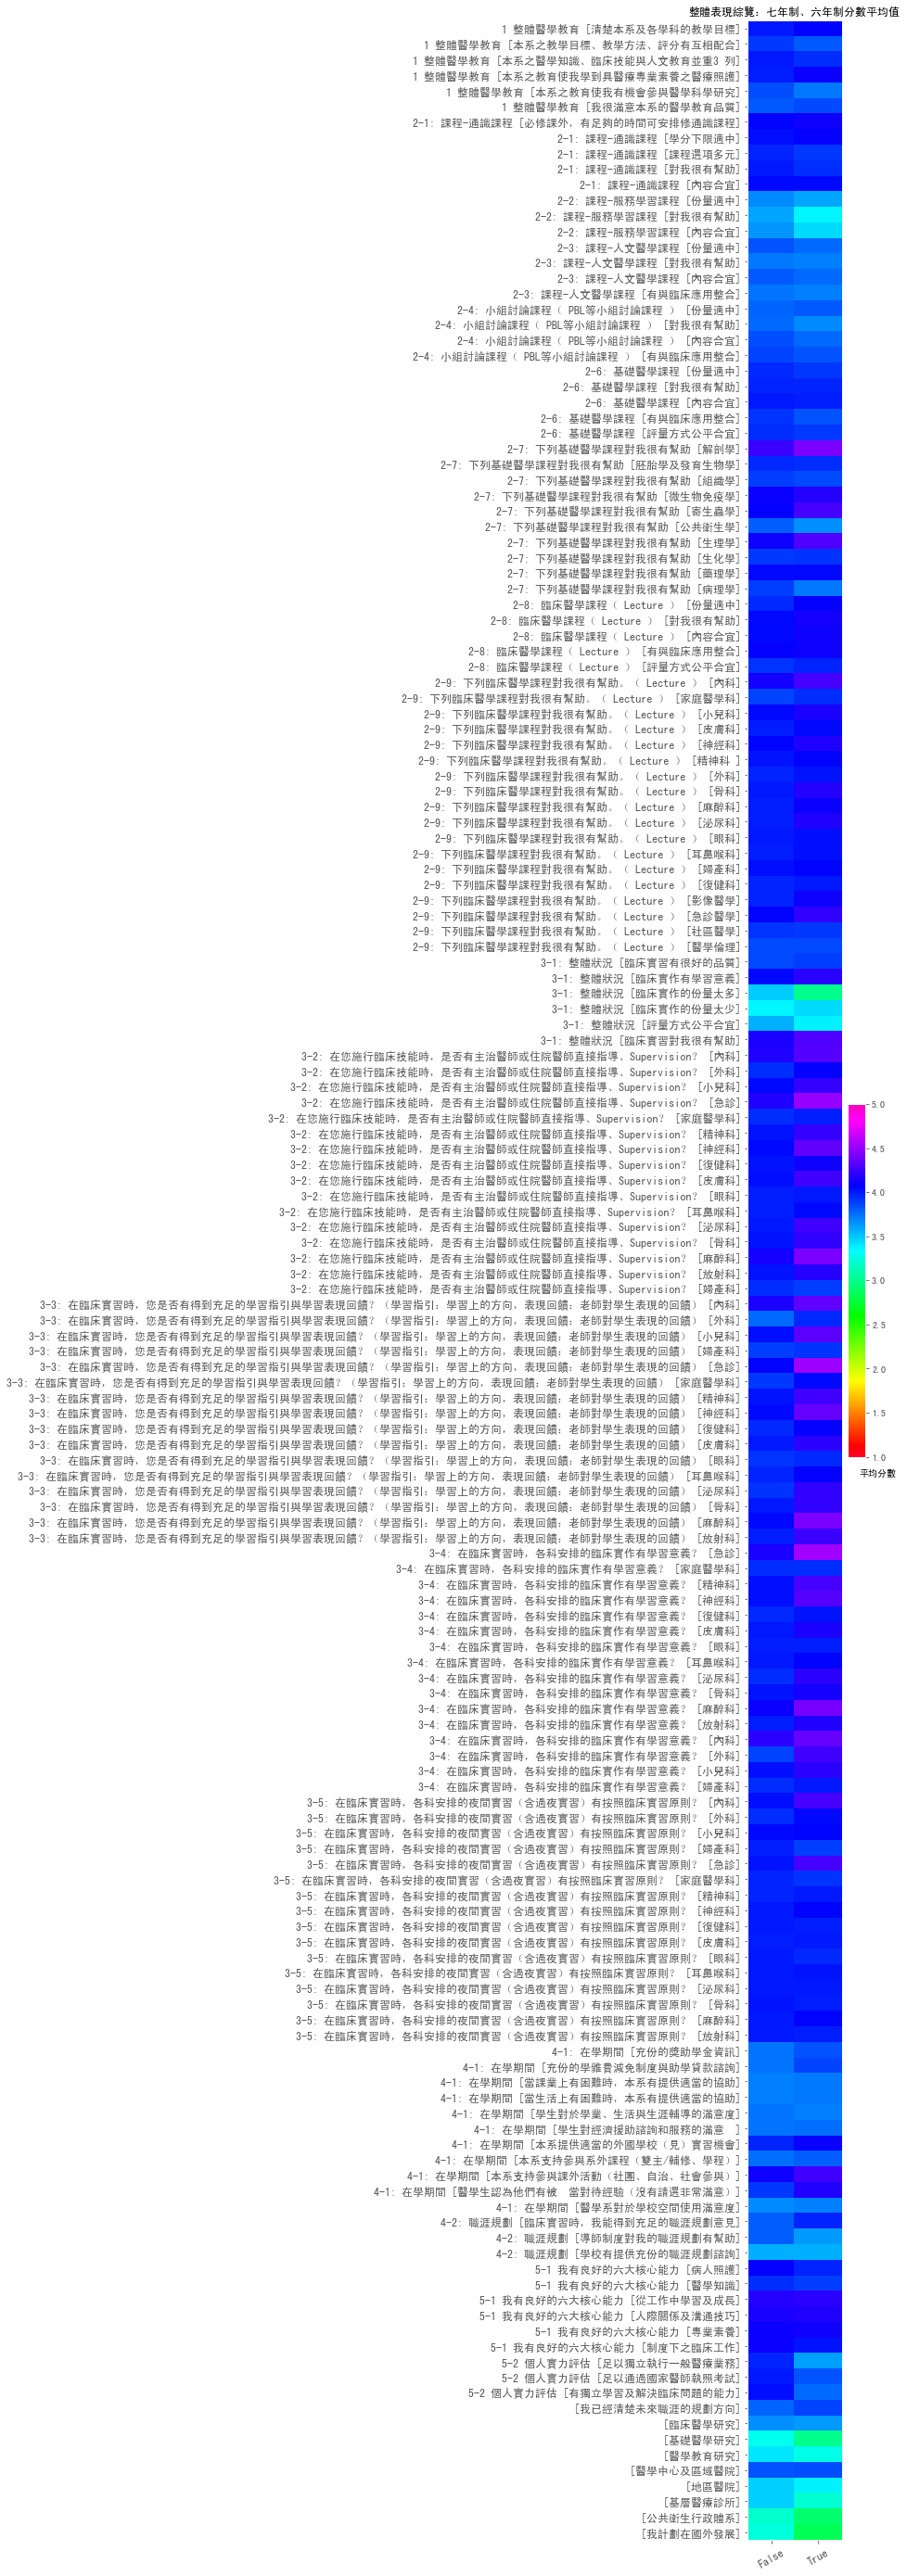

In [193]:
# 這裡只是把平均分數塗顏色
fig = plt.figure(figsize = (5,50))
ax = fig.add_subplot(1, 2, 1)
plt.pcolor(df_m, cmap='gist_rainbow', vmin=1, vmax=5)
plt.title('整體表現綜覽：七年制、六年制分數平均值', fontsize = 'large')
plt.colorbar()
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(df_m.columns.values, fontsize ='large', rotation = 30)
plt.gca().invert_yaxis()
ax.set_yticks(np.arange(0.5, df_m.shape[0], 1.0))
ax.set_yticklabels(list(df_m.index.values), fontsize ='large')

fig.text(0.46, 0.445, '平均分數', va='center', )
# 十分有趣的事情是：六年制在臨床實習的滿意度普遍比七年制高 (雖然沒有檢測 statistical significance)

In [222]:
df.to_excel('../../GQ_102101_clean.xlsx') # 清過的資料先存起來，改天活得不耐煩再來把 99,98的一起拿進來看

In [201]:
# 接下來一樣六七年制分組，看看大家選科第一志願的分布是否有差異
specialty = df.groupby(by = 'six_year')['我計劃專科醫師選科的第一志願（不當醫師可跳過。沒有選項請選其他，並在三個志願後面填寫）'].value_counts(normalize = True)

In [210]:
# 這裡只是在做 data 形式的轉換好畫圖給你看
s = pd.DataFrame([specialty[False], specialty[True]], index = ['six_year', 'seven_year']).transpose()

In [211]:
# 給你愾一下原始的表格
s

,six_year,seven_year
內科,0.195652,0.161290
外科,0.184783,0.077419
急診,0.125000,0.161290
家醫科,0.070652,0.064516
婦產科,0.054348,0.051613
小兒科,0.054348,0.038710
眼科,0.043478,0.045161
影醫科,0.038043,0.019355
神經科,0.038043,0.038710
骨科,0.038043,0.096774


Text(0.46, 0.445, '比例')

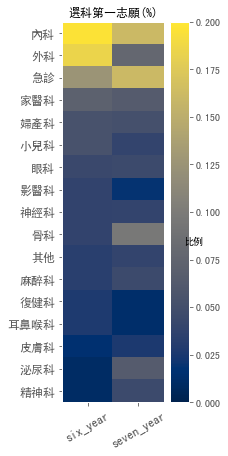

In [223]:
# 畫好了，六年制的同學看起來內外科魂爆棚，七年制較多人立定志向骨科泌尿科
fig = plt.figure(figsize = (5,7))
ax = fig.add_subplot(1, 2, 1)
plt.pcolor(s, cmap='cividis', vmin=0, vmax=0.2)
plt.title('選科第一志願(%)', fontsize = 'large')
plt.colorbar()
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(s.columns.values, fontsize ='large', rotation = 30)
plt.gca().invert_yaxis()
ax.set_yticks(np.arange(0.5, s.shape[0], 1.0))
ax.set_yticklabels(list(s.index.values), fontsize ='large')

fig.text(0.46, 0.445, '比例', va='center', )